# Logistic Regression

Let's see how simple it is to apply a logistic regression with Concrete ML.

### Import libraries

In [1]:
import time

import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

Some helpers for better visualization

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Generate a data-set
Let's generate a handcrafted training and test data-set. Let's also define a grid on which to 
test the classifier.

In [3]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=2,
    n_clusters_per_class=1,
)

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

b_min = np.min(X, axis=0)
b_max = np.max(X, axis=0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

x_test_grid, y_test_grid = np.meshgrid(
    np.linspace(b_min[0], b_max[0], 30), np.linspace(b_min[1], b_max[1], 30)
)
x_grid_test = np.vstack([x_test_grid.ravel(), y_test_grid.ravel()]).transpose()

### Train and predict using scikit-learn 
We now train a logistic regression model on the training set using scikit-learn. This model will
then be used for performance comparison. The predictions are therefore made on non-encrypted data.

In [4]:
sklearn_logr = SklearnLogisticRegression()
sklearn_logr.fit(x_train, y_train)
y_pred_test = sklearn_logr.predict(x_test)

### Visualize the decision boundary
We can visualize the classifier's probabilities on the test grid by plotting contours. 

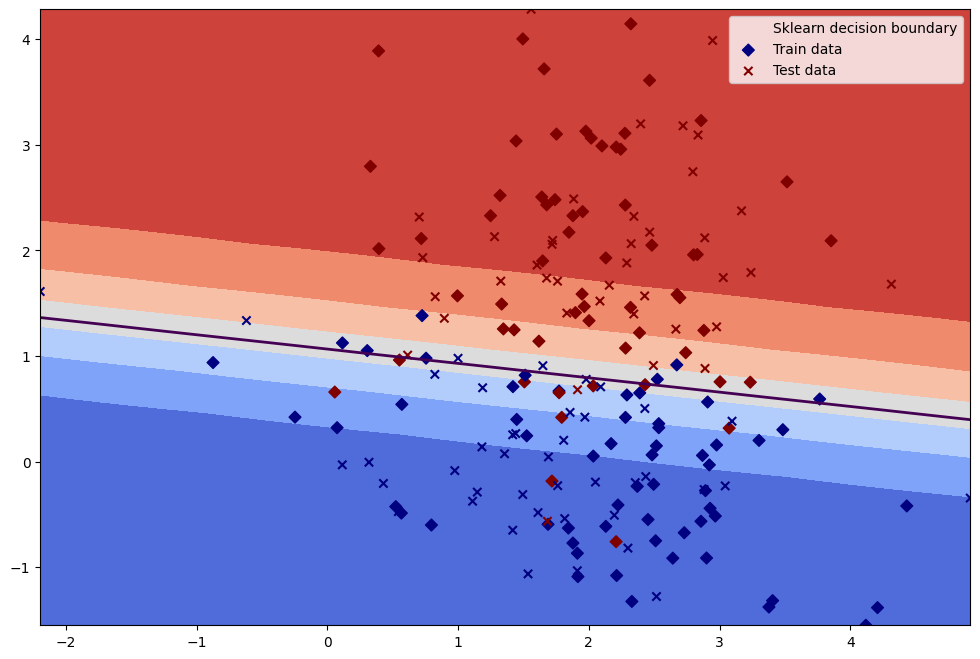

In [5]:
# Compute the scikit-learn classifier's probabilities on the domain
y_score_grid = sklearn_logr.predict_proba(x_grid_test)[:, 1]

plt.ioff()
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.contourf(x_test_grid, y_test_grid, y_score_grid.reshape(x_test_grid.shape), cmap="coolwarm")
CS1 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
)
CS1.collections[0].set_label("Sklearn decision boundary")
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker="D", cmap="jet", label="Train data")
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker="x", cmap="jet", label="Test data")
ax.legend(loc="upper right")
display(fig)

### Train using Concrete ML
Training a model using Concrete ML follows the same simple steps as with scikit-learn. 

Additionally, as for all linear models available in Concrete ML, a user has to set the `n_bits` 
parameter for initialization. This parameter can either be:
- a dictionary composed of `op_inputs` and `op_weights` keys. These parameters are given as 
    integers representing the number of bits over which the associated data should be quantized.

- an integer, representing the number of bits over which each input and weight should be quantized.
    Default is 8.

A more in-depth explanation about this quantization process used in linear models can be found in 
[the linear regression notebook](LinearRegression.ipynb).

In [6]:
concrete_logr = ConcreteLogisticRegression(n_bits=8)
concrete_logr.fit(x_train, y_train);

### Predict in the clear
It is possible to use the quantized model in order to evaluate its prediction on non-encrypted data.

In [7]:
# Predict on the test set
y_proba_q = concrete_logr.predict_proba(x_test)[:, 1]
y_pred_q = concrete_logr.predict(x_test)

# Compute the probabilities on the whole domain in order to be able to plot the contours
y_proba_q_grid = concrete_logr.predict_proba(x_grid_test)[:, 1]
y_pred_q_grid = concrete_logr.predict(x_grid_test)

### Compiling the model
A Concrete ML model needs to be compiled on a representative data-set (e.g., the training set or a
subset of it) in order to later be able to execute its inference in FHE.
This compilation process will generate an FHE circuit.

In [8]:
fhe_circuit = concrete_logr.compile(x_train)

### Generate the keys
We can determine the maximum bit width reached within the FHE circuit.

In [9]:
print(f"Generating a key for an {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for an 18-bit circuit


In [10]:
time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Key generation time: 0.0002 seconds


### Predict in FHE
Once the model is compiled, it is possible to execute the inference in FHE using encrypted data. 

In [11]:
time_begin = time.time()
y_pred_fhe = concrete_logr.predict(x_test, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(x_test):.4f} seconds per sample")

Execution time: 0.0024 seconds per sample


### Accuracy comparison
Let's now compare the accuracies from all three models:
- the scikit-learn model, computed in the clear using non-encrypted float values
- the Concrete ML quantized model, computed in the clear using non-encrypted integers
- the Concrete ML FHE model, computed in FHE using encrypted integers

In [12]:
sklearn_accuracy = accuracy_score(y_test, y_pred_test)
quantized_accuracy = accuracy_score(y_test, y_pred_q)
fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

print(f"Sklearn accuracy: {sklearn_accuracy:.4f}")
print(f"Quantized Clear Accuracy: {quantized_accuracy:.4f}")
print(f"FHE Accuracy: {fhe_accuracy:.4f}")

# Measure the error of the FHE quantized model with respect to the clear quantized model
concrete_score_difference = abs(fhe_accuracy - quantized_accuracy)
print(
    "\nRelative difference between Concrete-ml (quantized clear) and Concrete-ml (FHE) scores:",
    f"{concrete_score_difference:.2f}%",
)

# Measure the error of the FHE quantized model with respect to the clear scikit-learn float model
score_difference = abs(fhe_accuracy - sklearn_accuracy)
print(
    "Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores:",
    f"{score_difference:.2f}%",
)

Sklearn accuracy: 0.9250
Quantized Clear Accuracy: 0.9250
FHE Accuracy: 0.9250

Relative difference between Concrete-ml (quantized clear) and Concrete-ml (FHE) scores: 0.00%
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.00%


We can observe that all three accuracy scores are identical, suggesting the impact of quantization
is negligible for this model. 

### Plot the results
We can now plot both the scikit-learn and Concrete ML FHE models' predictions.

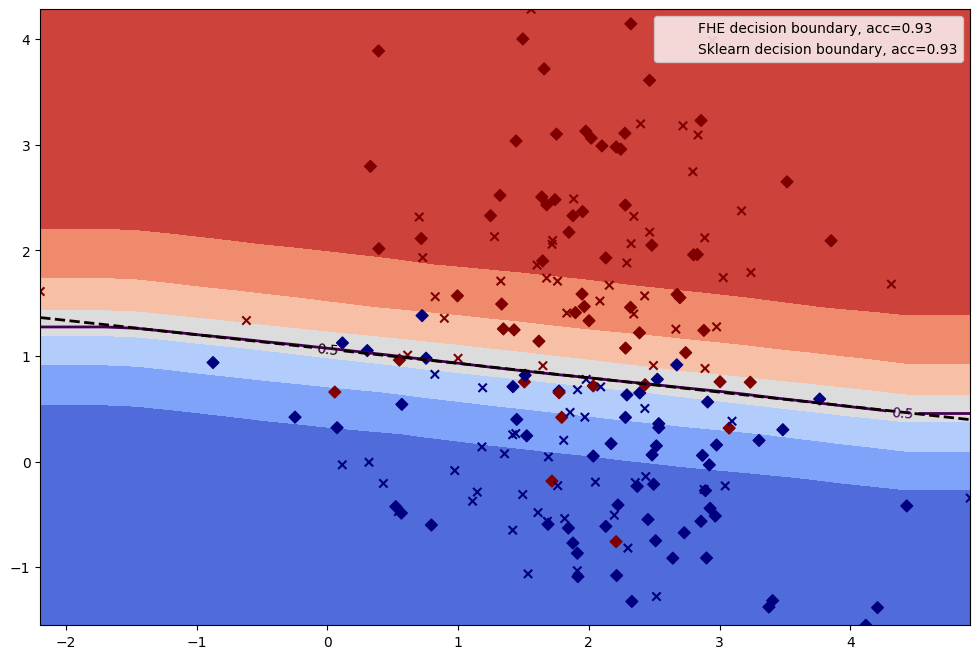

In [13]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.contourf(x_test_grid, y_test_grid, y_proba_q_grid.reshape(x_test_grid.shape), cmap="coolwarm")
CS1 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_proba_q_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
)
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="jet", marker="D")
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_pred_q, cmap="jet", marker="x")
CS2 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
    linestyles="dashed",
    cmap="hot",
)
ax.clabel(CS1, CS1.levels, inline=True, fontsize=10)
ax.clabel(CS2, CS2.levels, inline=True, fontsize=10)
CS1.collections[0].set_label(f"FHE decision boundary, acc={fhe_accuracy:.2f}")
CS2.collections[0].set_label(f"Sklearn decision boundary, acc={sklearn_accuracy:.2f}")
ax.legend(loc="upper right")
display(fig)

Decision boundaries from both models are almost identical. This shows executing a logistic regression
model in FHE doesn't really impact the performances compared to its scikit-learn equivalent.  

The plot above shows that the quantization introduced by Concrete ML didn't degrade the performance of the model.

But the quantization can highly degrade the performances of the model if the ranges of the data are very different per feature.

## Impact of pre-processing on quantization

This section shows the impact of different features distribution on model training.

Five datasets are considered:
- The raw dataset
- Data scaled to \[-1, 1\]
- Standard scaling
- One feature scaled on \[-1, 1\] and the other one on \[-100, 100\]
- One feature scaled on \[-1, 1\] and the other one on \[99, 101\]

In [14]:
from utils.scaling_comparison_utils import plot_data

In [15]:
scaler = MinMaxScaler((-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [17]:
x_train_unscaled = x_train_scaled.copy()
x_train_unscaled[:, 0] *= 100

x_test_unscaled = x_test_scaled.copy()
x_test_unscaled[:, 0] *= 100

In [18]:
x_train_shifted = x_train_scaled.copy()
x_train_shifted[:, 0] += 100

x_test_shifted = x_test_scaled.copy()
x_test_shifted[:, 0] += 100

In [19]:
n_bits = 5
random_state = 0
cml_clf = ConcreteLogisticRegression(n_bits=n_bits, random_state=random_state)
cml_clf_scaled = ConcreteLogisticRegression(n_bits=n_bits, random_state=random_state)
cml_clf_unscaled = ConcreteLogisticRegression(n_bits=n_bits, random_state=random_state)
cml_clf_shifted = ConcreteLogisticRegression(n_bits=n_bits, random_state=random_state)
cml_clf_normalized = ConcreteLogisticRegression(n_bits=n_bits, random_state=random_state)

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(8 * 3, 8 * 4))
models = [cml_clf, cml_clf_scaled, cml_clf_normalized, cml_clf_unscaled, cml_clf_shifted]
features_trains = [x_train, x_train_scaled, x_train_normalized, x_train_unscaled, x_train_shifted]
targets_trains = [y_train, y_train, y_train, y_train, y_train]
features_tests = [x_test, x_test_scaled, x_test_normalized, x_test_unscaled, x_test_shifted]
targets_tests = [y_test, y_test, y_test, y_test, y_test]
names = ["unchanged", "min-max-transformed", "normalized", "unscaled", "shifted"]

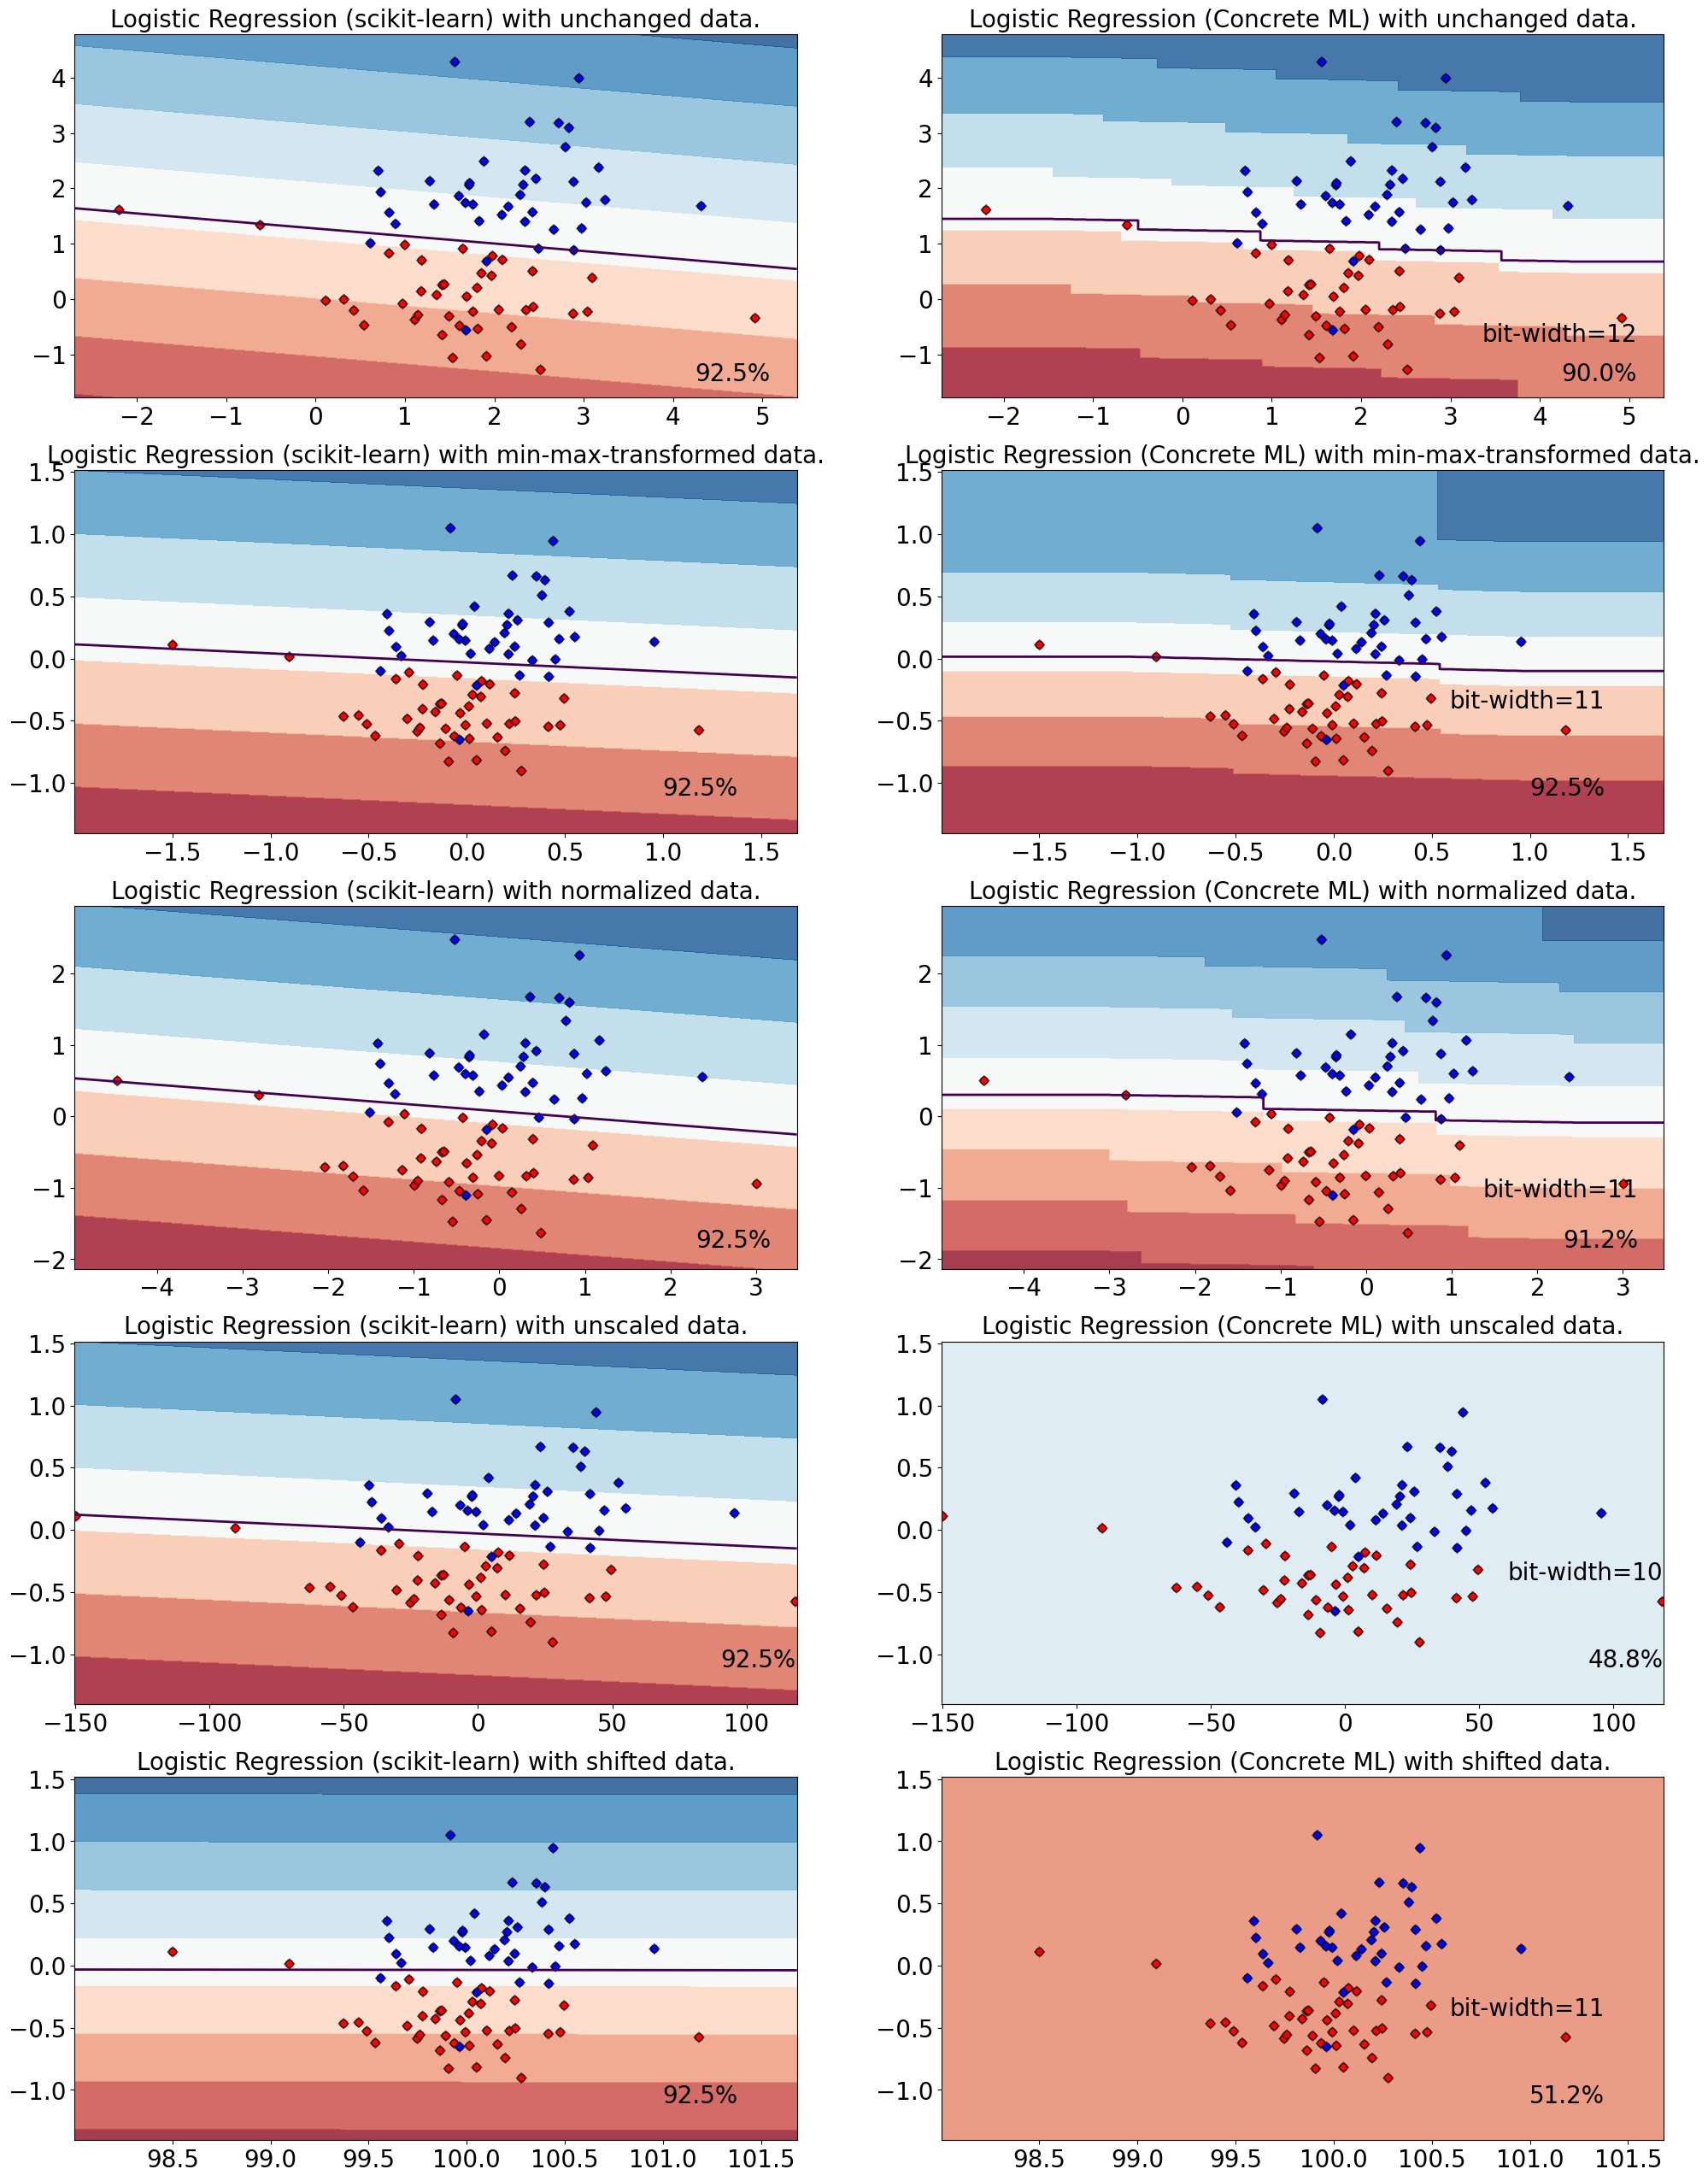

In [21]:
for ax, model, features_train, targets_train, features_test, targets_test, name in zip(
    axes,
    models,
    features_trains,
    targets_trains,
    features_tests,
    targets_tests,
    names,
):
    plot_data(ax, features_train, targets_train, features_test, targets_test, model, name)
display(fig)

The graph above showcases how the quantization needed for FHE introduced by Concrete ML is affected by transformations of the features.

What is showcased is that having either all features enclosed in the same range `[a, b]` or all features following a normal distribution with $\sigma=1$ and $\mu=0$ yields better results than non-processed data.

This is explained by the fact that all features are quantized using the same parameters, so to have a shared quantized representation in which all features keep some information it's very important to have similar distributions for all features.